In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

#from utils import mnist, plot_graphs, plot_mnist
import numpy as np

In [64]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def fmnist(batch_size=50, valid=0, shuffle=True, transform=fmnist_transform, path='./FMNIST_data'):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    #train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [65]:
train_loader, valid_loader, test_loader = fmnist(valid=10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


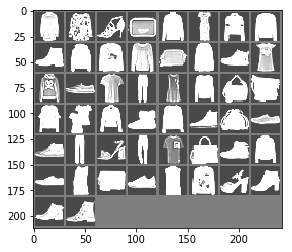

tensor([ 6,  6,  5,  8,  6,  3,  4,  2,  9,  4,  2,  2,  8,  4,
         7,  3,  2,  7,  0,  1,  6,  2,  8,  8,  2,  0,  4,  9,
         6,  7,  8,  7,  7,  1,  5,  1,  0,  8,  9,  6,  7,  0,
         8,  7,  2,  2,  5,  9,  9,  9])


In [67]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [68]:
#for (data, target) in enumerate(train_loader):
    #print(data)
#    print(target)
    #plot_mnist(data, [28,28])
#sample((n,))

In [83]:
class Net_overfit(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-2, l2=0.):
        super(Net_overfit, self).__init__()
        self.fc1 = nn.Linear(28*28, 28*28)
        self.fc2 = nn.Linear(28*28, 28*14)
        self.fc3 = nn.Linear(28*14 , 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(28*28)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        #self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [84]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [85]:
#models = {'default': Net_overfit(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
models = {'default': Net_overfit(False, False), 'bn': Net_overfit(True, False), 'drop': Net_overfit(False, True), 'both': Net_overfit(True, True) }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [86]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                #test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                test_loss[k] += m.loss(output, target).item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [87]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.319963 bn: 2.312448 drop: 2.284191 both: 2.282483
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.817746 bn: 0.695850 drop: 0.802946 both: 0.669004
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.738969 bn: 0.654928 drop: 0.719728 both: 0.632131
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.595815 bn: 0.448854 drop: 0.613339 both: 0.446253
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.504930 bn: 0.402316 drop: 0.490162 both: 0.387052
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.636832 bn: 0.614959 drop: 0.625694 both: 0.611217
Test set:
default: Loss: 0.0101	Accuracy: 8161/10000 (81%)
bn: Loss: 0.0093	Accuracy: 8327/10000 (83%)
drop: Loss: 0.0101	Accuracy: 8176/10000 (81%)
both: Loss: 0.0093	Accuracy: 8312/10000 (83%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.531481 bn: 0.420944 drop: 0.505809 both: 0.455277
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.521394 bn: 0.505157 drop: 0.530783 both

Train Epoch: 11 [10000/50000 (20%)]	Losses default: 0.130775 bn: 0.156619 drop: 0.119626 both: 0.138500
Train Epoch: 11 [20000/50000 (40%)]	Losses default: 0.307419 bn: 0.300375 drop: 0.305281 both: 0.288130
Train Epoch: 11 [30000/50000 (60%)]	Losses default: 0.341986 bn: 0.243206 drop: 0.354374 both: 0.257911
Train Epoch: 11 [40000/50000 (80%)]	Losses default: 0.335717 bn: 0.265983 drop: 0.350736 both: 0.231225
Train Epoch: 11 [50000/50000 (100%)]	Losses default: 0.324780 bn: 0.259582 drop: 0.324395 both: 0.267163
Test set:
default: Loss: 0.0070	Accuracy: 8746/10000 (87%)
bn: Loss: 0.0067	Accuracy: 8771/10000 (87%)
drop: Loss: 0.0070	Accuracy: 8754/10000 (87%)
both: Loss: 0.0066	Accuracy: 8796/10000 (87%)

Train Epoch: 12 [0/50000 (0%)]	Losses default: 0.328565 bn: 0.350584 drop: 0.323810 both: 0.358283
Train Epoch: 12 [10000/50000 (20%)]	Losses default: 0.265281 bn: 0.192232 drop: 0.259373 both: 0.201333
Train Epoch: 12 [20000/50000 (40%)]	Losses default: 0.324952 bn: 0.267554 drop: 

Train Epoch: 21 [20000/50000 (40%)]	Losses default: 0.248962 bn: 0.201882 drop: 0.225684 both: 0.196074
Train Epoch: 21 [30000/50000 (60%)]	Losses default: 0.109397 bn: 0.110233 drop: 0.119547 both: 0.116691
Train Epoch: 21 [40000/50000 (80%)]	Losses default: 0.324005 bn: 0.322951 drop: 0.337349 both: 0.268464
Train Epoch: 21 [50000/50000 (100%)]	Losses default: 0.265988 bn: 0.188628 drop: 0.267233 both: 0.243522
Test set:
default: Loss: 0.0065	Accuracy: 8809/10000 (88%)
bn: Loss: 0.0062	Accuracy: 8889/10000 (88%)
drop: Loss: 0.0065	Accuracy: 8823/10000 (88%)
both: Loss: 0.0063	Accuracy: 8878/10000 (88%)

Train Epoch: 22 [0/50000 (0%)]	Losses default: 0.217755 bn: 0.222317 drop: 0.224984 both: 0.207754
Train Epoch: 22 [10000/50000 (20%)]	Losses default: 0.235970 bn: 0.151848 drop: 0.236690 both: 0.164012
Train Epoch: 22 [20000/50000 (40%)]	Losses default: 0.206899 bn: 0.184857 drop: 0.216104 both: 0.180669
Train Epoch: 22 [30000/50000 (60%)]	Losses default: 0.158953 bn: 0.171031 drop: 

Train Epoch: 31 [30000/50000 (60%)]	Losses default: 0.109119 bn: 0.052253 drop: 0.110046 both: 0.064971
Train Epoch: 31 [40000/50000 (80%)]	Losses default: 0.470962 bn: 0.392161 drop: 0.463213 both: 0.432581
Train Epoch: 31 [50000/50000 (100%)]	Losses default: 0.176763 bn: 0.104537 drop: 0.162547 both: 0.138373
Test set:
default: Loss: 0.0063	Accuracy: 8869/10000 (88%)
bn: Loss: 0.0065	Accuracy: 8900/10000 (89%)
drop: Loss: 0.0063	Accuracy: 8883/10000 (88%)
both: Loss: 0.0064	Accuracy: 8923/10000 (89%)

Train Epoch: 32 [0/50000 (0%)]	Losses default: 0.123347 bn: 0.067542 drop: 0.120539 both: 0.072842
Train Epoch: 32 [10000/50000 (20%)]	Losses default: 0.278357 bn: 0.162518 drop: 0.273070 both: 0.154027
Train Epoch: 32 [20000/50000 (40%)]	Losses default: 0.151847 bn: 0.059391 drop: 0.131779 both: 0.084812
Train Epoch: 32 [30000/50000 (60%)]	Losses default: 0.169384 bn: 0.084793 drop: 0.170492 both: 0.122702
Train Epoch: 32 [40000/50000 (80%)]	Losses default: 0.286846 bn: 0.188707 drop: 

Train Epoch: 41 [40000/50000 (80%)]	Losses default: 0.085207 bn: 0.069135 drop: 0.079222 both: 0.080896
Train Epoch: 41 [50000/50000 (100%)]	Losses default: 0.116042 bn: 0.056075 drop: 0.123972 both: 0.093533
Test set:
default: Loss: 0.0067	Accuracy: 8854/10000 (88%)
bn: Loss: 0.0075	Accuracy: 8860/10000 (88%)
drop: Loss: 0.0066	Accuracy: 8878/10000 (88%)
both: Loss: 0.0071	Accuracy: 8910/10000 (89%)

Train Epoch: 42 [0/50000 (0%)]	Losses default: 0.326692 bn: 0.209958 drop: 0.270211 both: 0.174904
Train Epoch: 42 [10000/50000 (20%)]	Losses default: 0.238537 bn: 0.130929 drop: 0.232642 both: 0.094522
Train Epoch: 42 [20000/50000 (40%)]	Losses default: 0.120483 bn: 0.071531 drop: 0.112984 both: 0.054401
Train Epoch: 42 [30000/50000 (60%)]	Losses default: 0.090461 bn: 0.090106 drop: 0.090400 both: 0.065507
Train Epoch: 42 [40000/50000 (80%)]	Losses default: 0.254089 bn: 0.165924 drop: 0.269807 both: 0.168769
Train Epoch: 42 [50000/50000 (100%)]	Losses default: 0.224081 bn: 0.186197 drop:

Train Epoch: 51 [50000/50000 (100%)]	Losses default: 0.320342 bn: 0.323480 drop: 0.349898 both: 0.272586
Test set:
default: Loss: 0.0084	Accuracy: 8704/10000 (87%)
bn: Loss: 0.0076	Accuracy: 8917/10000 (89%)
drop: Loss: 0.0087	Accuracy: 8682/10000 (86%)
both: Loss: 0.0084	Accuracy: 8806/10000 (88%)

Train Epoch: 52 [0/50000 (0%)]	Losses default: 0.279849 bn: 0.143258 drop: 0.311169 both: 0.134573
Train Epoch: 52 [10000/50000 (20%)]	Losses default: 0.066665 bn: 0.139998 drop: 0.073202 both: 0.152309
Train Epoch: 52 [20000/50000 (40%)]	Losses default: 0.144762 bn: 0.171557 drop: 0.124045 both: 0.129342
Train Epoch: 52 [30000/50000 (60%)]	Losses default: 0.184530 bn: 0.065930 drop: 0.167587 both: 0.144969
Train Epoch: 52 [40000/50000 (80%)]	Losses default: 0.116970 bn: 0.109849 drop: 0.143800 both: 0.150009
Train Epoch: 52 [50000/50000 (100%)]	Losses default: 0.227451 bn: 0.184361 drop: 0.214440 both: 0.121305
Test set:
default: Loss: 0.0072	Accuracy: 8837/10000 (88%)
bn: Loss: 0.0082	Acc

Test set:
default: Loss: 0.0068	Accuracy: 8911/10000 (89%)
bn: Loss: 0.0085	Accuracy: 8853/10000 (88%)
drop: Loss: 0.0069	Accuracy: 8936/10000 (89%)
both: Loss: 0.0090	Accuracy: 8845/10000 (88%)

Train Epoch: 62 [0/50000 (0%)]	Losses default: 0.090542 bn: 0.082121 drop: 0.104188 both: 0.094940
Train Epoch: 62 [10000/50000 (20%)]	Losses default: 0.226123 bn: 0.043490 drop: 0.194927 both: 0.090416
Train Epoch: 62 [20000/50000 (40%)]	Losses default: 0.098197 bn: 0.032728 drop: 0.079069 both: 0.069939
Train Epoch: 62 [30000/50000 (60%)]	Losses default: 0.169912 bn: 0.086039 drop: 0.143029 both: 0.130019
Train Epoch: 62 [40000/50000 (80%)]	Losses default: 0.130901 bn: 0.178362 drop: 0.115817 both: 0.106300
Train Epoch: 62 [50000/50000 (100%)]	Losses default: 0.123385 bn: 0.073245 drop: 0.121794 both: 0.061631
Test set:
default: Loss: 0.0068	Accuracy: 8909/10000 (89%)
bn: Loss: 0.0084	Accuracy: 8890/10000 (88%)
drop: Loss: 0.0069	Accuracy: 8933/10000 (89%)
both: Loss: 0.0081	Accuracy: 8898/1

Train Epoch: 72 [10000/50000 (20%)]	Losses default: 0.089378 bn: 0.069438 drop: 0.117223 both: 0.067293
Train Epoch: 72 [20000/50000 (40%)]	Losses default: 0.089582 bn: 0.078879 drop: 0.090069 both: 0.038438
Train Epoch: 72 [30000/50000 (60%)]	Losses default: 0.083505 bn: 0.023593 drop: 0.064054 both: 0.019946
Train Epoch: 72 [40000/50000 (80%)]	Losses default: 0.079432 bn: 0.111751 drop: 0.071208 both: 0.080914
Train Epoch: 72 [50000/50000 (100%)]	Losses default: 0.031268 bn: 0.034217 drop: 0.036850 both: 0.012385
Test set:
default: Loss: 0.0070	Accuracy: 8915/10000 (89%)
bn: Loss: 0.0086	Accuracy: 8916/10000 (89%)
drop: Loss: 0.0071	Accuracy: 8960/10000 (89%)
both: Loss: 0.0085	Accuracy: 8939/10000 (89%)

Train Epoch: 73 [0/50000 (0%)]	Losses default: 0.106251 bn: 0.071753 drop: 0.097779 both: 0.054614
Train Epoch: 73 [10000/50000 (20%)]	Losses default: 0.077082 bn: 0.026834 drop: 0.067225 both: 0.023217
Train Epoch: 73 [20000/50000 (40%)]	Losses default: 0.049512 bn: 0.026987 drop: 

Train Epoch: 82 [20000/50000 (40%)]	Losses default: 0.046998 bn: 0.027872 drop: 0.024373 both: 0.014943
Train Epoch: 82 [30000/50000 (60%)]	Losses default: 0.036574 bn: 0.010430 drop: 0.034477 both: 0.016312
Train Epoch: 82 [40000/50000 (80%)]	Losses default: 0.033909 bn: 0.039366 drop: 0.034260 both: 0.026398
Train Epoch: 82 [50000/50000 (100%)]	Losses default: 0.168679 bn: 0.037655 drop: 0.166578 both: 0.073265
Test set:
default: Loss: 0.0080	Accuracy: 8895/10000 (88%)
bn: Loss: 0.0102	Accuracy: 8874/10000 (88%)
drop: Loss: 0.0081	Accuracy: 8904/10000 (89%)
both: Loss: 0.0096	Accuracy: 8910/10000 (89%)

Train Epoch: 83 [0/50000 (0%)]	Losses default: 0.049444 bn: 0.058086 drop: 0.083968 both: 0.077429
Train Epoch: 83 [10000/50000 (20%)]	Losses default: 0.087674 bn: 0.055795 drop: 0.079847 both: 0.059638
Train Epoch: 83 [20000/50000 (40%)]	Losses default: 0.055069 bn: 0.067574 drop: 0.039996 both: 0.058378
Train Epoch: 83 [30000/50000 (60%)]	Losses default: 0.027702 bn: 0.028609 drop: 

Train Epoch: 92 [30000/50000 (60%)]	Losses default: 0.021044 bn: 0.030395 drop: 0.018112 both: 0.025496
Train Epoch: 92 [40000/50000 (80%)]	Losses default: 0.027844 bn: 0.012452 drop: 0.015922 both: 0.034786
Train Epoch: 92 [50000/50000 (100%)]	Losses default: 0.031638 bn: 0.022017 drop: 0.028653 both: 0.010837
Test set:
default: Loss: 0.0082	Accuracy: 8905/10000 (89%)
bn: Loss: 0.0097	Accuracy: 8919/10000 (89%)
drop: Loss: 0.0084	Accuracy: 8915/10000 (89%)
both: Loss: 0.0098	Accuracy: 8889/10000 (88%)

Train Epoch: 93 [0/50000 (0%)]	Losses default: 0.021397 bn: 0.011299 drop: 0.035927 both: 0.018105
Train Epoch: 93 [10000/50000 (20%)]	Losses default: 0.039076 bn: 0.006689 drop: 0.051936 both: 0.008311
Train Epoch: 93 [20000/50000 (40%)]	Losses default: 0.043842 bn: 0.009970 drop: 0.075156 both: 0.006913
Train Epoch: 93 [30000/50000 (60%)]	Losses default: 0.011281 bn: 0.003414 drop: 0.009695 both: 0.004164
Train Epoch: 93 [40000/50000 (80%)]	Losses default: 0.069479 bn: 0.029431 drop: 

In [25]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

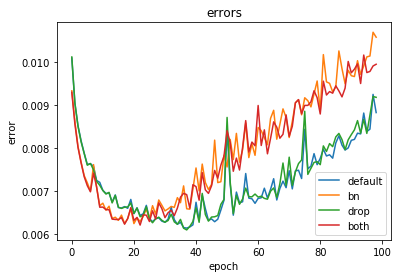

In [88]:
plot_graphs(test_log, 'loss')

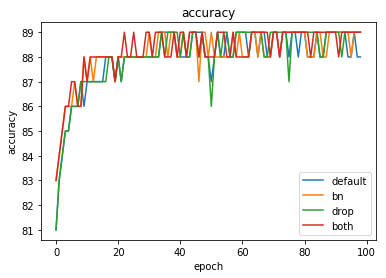

In [89]:
plot_graphs(test_log, 'accuracy')